<a href="https://colab.research.google.com/github/StolkHU/MADS-ML-AdriaanS/blob/main/notebooks/4_tuning_networks/04_transfer_learning_with_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<td>
<a href="https://colab.research.google.com/github/raoulg/MADS-MachineLearning-course/blob/master/notebooks/4_tuning_networks/04_transfer_learning_with_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</td>

In [1]:
import os
# Check if the notebook is running on Google Colab
colab = False
if 'COLAB_GPU' in os.environ:
    colab = True
    # Running on Google Colab; install loguru
    !pip install mads_datasets mltrainer loguru
else:
    # Not running on Google Colab; you might be on a local setup
    print("Not running on Google Colab. Ensure dependencies are installed as needed.")

In [2]:
from pathlib import Path
from loguru import logger
import torch
import matplotlib.pyplot as plt

Let's revisit the flowers dataset from the first lesson

In [3]:
from mads_datasets import DatasetFactoryProvider, DatasetType

flowersfactory = DatasetFactoryProvider.create_factory(DatasetType.FLOWERS)
streamers = flowersfactory.create_datastreamer(batchsize=32)

2025-05-20 18:30:20.300 | INFO     | mads_datasets.base:download_data:94 - Start download...
  0%|          | 0.00/229M [00:00<?, ?iB/s]2025-05-20 18:30:20.568 | INFO     | mads_datasets.datatools:get_file:105 - Downloading /root/.cache/mads_datasets/flowers/flowers.tgz
100%|██████████| 229M/229M [00:10<00:00, 21.0MiB/s]
2025-05-20 18:30:31.464 | INFO     | mads_datasets.datatools:extract:128 - Unzipping /root/.cache/mads_datasets/flowers/flowers.tgz
2025-05-20 18:30:33.843 | INFO     | mads_datasets.base:download_data:112 - Digest of /root/.cache/mads_datasets/flowers/flowers.tgz matches expected digest
2025-05-20 18:30:33.843 | INFO     | mads_datasets.base:download_data:117 - Removing unzipped file /root/.cache/mads_datasets/flowers/flowers.tgz


We have just about 3000 images. To get more out of our data, we will use a technique called 'data augmentation'. When an image if flipped, or cropped, we get a different image, preventing the model to overfit on the quirks of this small dataset. We will also normalize the images to the mean and standard deviation used when training resnet; this is not strictly necessary, but should make it a bit easier for the model to work with our images.

In [4]:
from torchvision import transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Because we want to crop the images, lets make our images during preprocessing a bit bigger, so we actually have something to crop:

In [5]:
flowersfactory.settings

dataset_url: https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
filename: flowers.tgz
name: flowers
unzip: True
formats: [<FileTypes.JPG: '.jpg'>]
digest: 6f87fb78e9cc9ab41eff2015b380011d
trainfrac: 0.8
img_size: (224, 224)

In [6]:
flowersfactory.settings.img_size = (500, 500)

With this modification of the settings, we can create the dataset.
We can see our images are actually 500x500 pixels now.

The transformations are just a function; we can input the img and get a transformed image out. Let try that,
and visualise the result:

PS: if you dont have enough RAM on colab (eg 12GB), the cell below might crash your notebook (because it recreates the dataset);
the first cell in this notebook has set the value of 'colab' to True if you are on colab, to avoid this issue.

In [7]:
if not colab:
    datasets = flowersfactory.create_dataset()
    traindataset = datasets["train"]
    img, lab = traindataset[0]
    logger.info(f"original shape: {img.shape}")
    # original shape: torch.Size([3, 500, 500])
    transformed_img = data_transforms["train"](img)
    logger.info(f"transformed shape: {transformed_img.shape}")
    # transformed shape: torch.Size([3, 224, 224])

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img.numpy().transpose(1, 2, 0))
    ax[1].imshow(transformed_img.numpy().transpose(1, 2, 0))

Instead of using the BasePreprocessor, we will squeeze in the transformer. Lets make that:

In [8]:
class AugmentPreprocessor():
    def __init__(self, transform):
        self.transform = transform
    def __call__(self, batch: list[tuple]) -> tuple[torch.Tensor, torch.Tensor]:
        X, y = zip(*batch)
        X = [self.transform(x) for x in X]
        return torch.stack(X), torch.stack(y)

Now we can create an separate preprocessor for train and validation:

In [9]:
trainprocessor= AugmentPreprocessor(data_transforms["train"])
validprocessor = AugmentPreprocessor(data_transforms["val"])

And add that as the preprocessor for train and validation streamers. We do it like this because by default we can only provide a single preprocessor for both training and validation.

In [10]:
train = streamers["train"]
valid = streamers["valid"]
train.preprocessor = trainprocessor
valid.preprocessor = validprocessor
trainstreamer = train.stream()
validstreamer = valid.stream()

Let's confirm this works:

In [11]:
X, y = next(trainstreamer)
X.shape, y.shape


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

And lets visualise a random batch of images

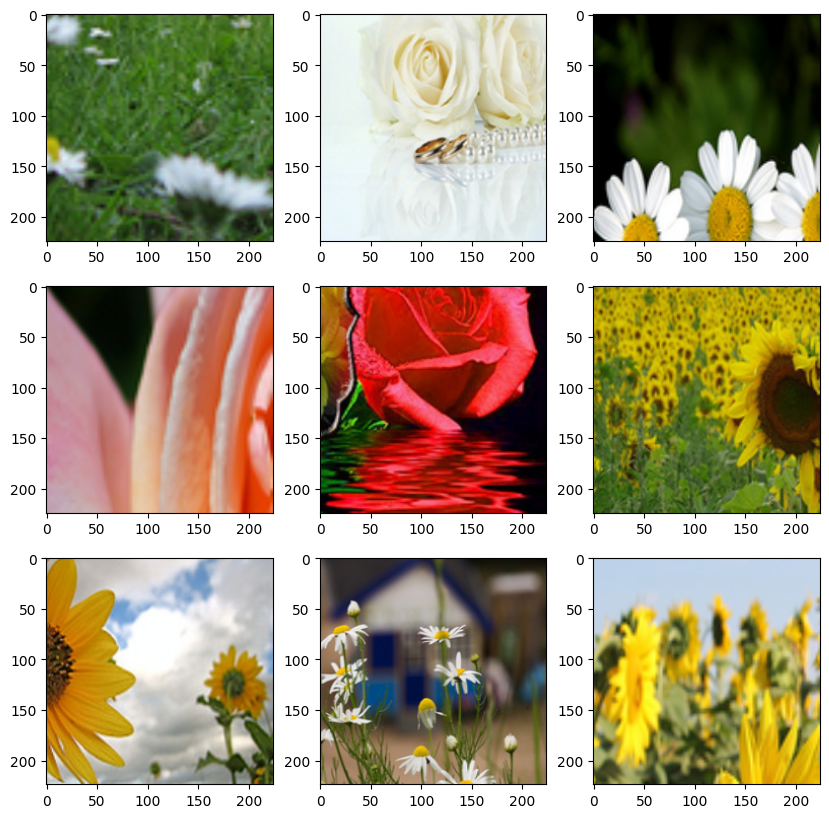

In [12]:
import matplotlib.pyplot as plt
import numpy as np
img = X.permute(0, 2, 3, 1).numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
fig, axs = plt.subplots(3, 3, figsize=(10,10))
axs = axs.ravel()
for i in range(9):
    axs[i].imshow(img[i])

Instead of building our own resnet, we will just download a pretrained version. This saves us many hours of training.

In [13]:
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
resnet = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


In [14]:
ResNet18_Weights.DEFAULT

ResNet18_Weights.IMAGENET1K_V1

In [15]:
yhat = resnet(X)
yhat.shape


torch.Size([32, 1000])

However, the resnet is trained for 1000 classes. We have just 5...

We will swap the last layer and retrain the model.

First, we freeze all pretrained layers:

In [16]:
for name, param in resnet.named_parameters():
    param.requires_grad = False


If you study the resnet implementation on [github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L206) you can see that the last layer is named `.fc`, like this:

```
 self.fc = nn.Linear(512 * block.expansion, num_classes)
 ```

This is a Linear layer, mapping from 512 * block.expansion to num_classes.


so we will swap that for our own. To do so we need to figure out how many features go into the .fc layer.
We can retrieve the incoming amount of features for the current `.fc` with `.in_features`

In [17]:
print(type(resnet.fc))
in_features = resnet.fc.in_features
in_features

<class 'torch.nn.modules.linear.Linear'>


512

Let's swap that layer with a minimal network. Sometimes just a linear layer is enough, sometimes you want to add two layers and some dropout.
Play around to see the difference!

In [18]:
import torch.nn as nn

resnet.fc = nn.Sequential(
    nn.Linear(in_features, 5)
    # nn.Linear(in_features, 128), nn.ReLU(), nn.Dropout(0.1), nn.Linear(128, 5)
)


In [19]:
yhat = resnet(X)
yhat.shape


torch.Size([32, 5])

So, we have a fully trained resnet, but we added two layers at the end that transforms everything into 5 classes.
These layers are random, so we need to train them for some epochs

In [20]:
from mltrainer import metrics
accuracy = metrics.Accuracy()

This will take some time to train (about 4 min per epoch), you could scale down to amount of trainsteps to speed things up.

You will start with a fairly high learning rate (0.01), and if the learning stops, after patience epochs the learning rate gets halved.

In [21]:
len(train), len(valid)

(91, 22)

In [22]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"
    logger.warning("This model will take 15-20 minutes on CPU. Consider using accelaration, eg with google colab (see button on top of the page)")
logger.info(f"Using {device}")

2025-05-20 18:32:37.480 | INFO     | __main__:<cell line: 0>:8 - Using cuda


We are going to use SGD as optimizer and a stepLR as scheduler.

In [23]:
from torch import optim
optimizer = optim.SGD
scheduler = optim.lr_scheduler.StepLR

To make this actually learn enough, you should increase the epochs to about 30.

In [24]:
from mltrainer import Trainer, TrainerSettings, ReportTypes

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellogs/flowers",
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD],
    optimizer_kwargs= {'lr': 0.1, 'weight_decay': 1e-05, 'momentum': 0.9},
    scheduler_kwargs= {'step_size' : 10, 'gamma' : 0.1},
    earlystop_kwargs= None,
)
settings

2025-05-20 18:32:42.974 | INFO     | mltrainer.settings:check_path:60 - Created logdir /content/modellogs/flowers


epochs: 3
metrics: [Accuracy]
logdir: modellogs/flowers
train_steps: 91
valid_steps: 22
reporttypes: [<ReportTypes.TENSORBOARD: 'TENSORBOARD'>]
optimizer_kwargs: {'lr': 0.1, 'weight_decay': 1e-05, 'momentum': 0.9}
scheduler_kwargs: {'step_size': 10, 'gamma': 0.1}
earlystop_kwargs: None

In [25]:
trainer = Trainer(
    model=resnet,
    settings=settings,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=scheduler,
    device=device,
    )

2025-05-20 18:32:45.333 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/flowers/20250520-183245


In [26]:
# note: this will be very slow without acceleration!
trainer.loop()

100%|██████████| 91/91 [00:08<00:00, 10.76it/s]
2025-05-20 18:33:07.098 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 5.6591 test 7.3975 metric ['0.7372']
100%|██████████| 91/91 [00:07<00:00, 11.75it/s]
2025-05-20 18:33:16.539 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 4.0274 test 2.8106 metric ['0.8523']
100%|██████████| 91/91 [00:07<00:00, 12.69it/s]
2025-05-20 18:33:26.047 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 2.8935 test 2.5946 metric ['0.8722']
100%|██████████| 3/3 [00:29<00:00,  9.73s/it]


In [31]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful